In [1]:
import json
import pprint
import os
import hashlib
from collections import defaultdict

In [2]:
allowlist = [
    "font-size",
    "font-family",
    "inline-size",
    "block-size",
    "width",
    "height",
    "aspect-ratio",
    "orientation",
    "line-height"
]


def filter_json_by_allowlist(json_object, allowlist):
    filtered_json = {}
    for key, properties in json_object.items():
        filtered_properties = {
            prop: value for prop, value in properties.items() if prop in allowlist
        }
        filtered_json[key] = filtered_properties
    return filtered_json

In [3]:
# hash_to_meta = dict()
# hash_to_os = dict()
# hash_to_browser_release = dict()
host_to_browser_to_exp_to_fingerprint = defaultdict(lambda: defaultdict(lambda: defaultdict(str)))

In [4]:
hostnames = [
    "win10vm",
    "win11vm",
    "ubuntu22vm",
    "macbook",
    "tablet",
    "pixel",
    "iphone13",
]

browsers = [
    "chrome",
    "edge",
    "opera",
    "brave",
    "safari",
    "firefox",
    "tor",
    "ghostery",
]

In [5]:
directory = "./results"

for testsuite in os.listdir(directory):
    for filename in os.listdir(directory + "/" + testsuite):
        if not filename.endswith(".json"):
            continue

        FILE_A = filename
        DATA_A = None

        with open(f"{directory}/{testsuite}/{FILE_A}", "r") as json_file:
            DATA_A = json.load(json_file)

        meta = DATA_A["meta"]
        DATA = DATA_A["results"]

        if testsuite == "props":
            DATA = filter_json_by_allowlist(DATA, allowlist)

        if meta["host"] not in hostnames:
            continue
        if meta["browser"] not in browsers:
            continue

        hash = hashlib.md5(json.dumps(DATA).encode()).hexdigest()
        host_to_browser_to_exp_to_fingerprint[meta["host"]][meta["browser"]][meta["experiment"]] = hash

In [6]:
host_to_browser_to_exp_to_fingerprint = json.loads(json.dumps(host_to_browser_to_exp_to_fingerprint))

In [7]:
for host in host_to_browser_to_exp_to_fingerprint:
    for browser in browsers:
        if browser not in host_to_browser_to_exp_to_fingerprint[host]:
            host_to_browser_to_exp_to_fingerprint[host][browser] = dict()
pprint.pprint(host_to_browser_to_exp_to_fingerprint)

{'iphone13': {'brave': {'calc': '827bd4e5eb24207d1a389d0a1566c92b',
                        'fontcontainer': '8adaa5df8400ef4906e2063b3c12ca11',
                        'props': 'bc53890a92e57d55ac49ff5e68af2656',
                        'valuecontainer': 'ef37c745aeb40a14caea33ca8daf0f70'},
              'chrome': {'calc': '827bd4e5eb24207d1a389d0a1566c92b',
                         'fontcontainer': '8adaa5df8400ef4906e2063b3c12ca11',
                         'props': 'bc53890a92e57d55ac49ff5e68af2656',
                         'valuecontainer': 'ef37c745aeb40a14caea33ca8daf0f70'},
              'edge': {'calc': '827bd4e5eb24207d1a389d0a1566c92b',
                       'fontcontainer': '8adaa5df8400ef4906e2063b3c12ca11',
                       'props': 'bc53890a92e57d55ac49ff5e68af2656',
                       'valuecontainer': 'ef37c745aeb40a14caea33ca8daf0f70'},
              'firefox': {'calc': '827bd4e5eb24207d1a389d0a1566c92b',
                          'fontcontainer': '8adaa5d

In [8]:
clusters = defaultdict(set)
combinations = set()

labels = []
cm = []
for host_a in hostnames:
    for browser_a in browsers:
        line = []
        for host_b in hostnames:
            for browser_b in browsers:
                fp_a = host_to_browser_to_exp_to_fingerprint[host_a][browser_a]
                fp_b = host_to_browser_to_exp_to_fingerprint[host_b][browser_b]
                fp_a_serialized, fp_b_serialized = "", ""
                if "calc" in fp_a and "calc" in fp_b:
                    fp_a_serialized += fp_a["calc"]
                    fp_b_serialized += fp_b["calc"]
                # if browser_a != "brave" and browser_b != "brave":
                #     if "fontcontainer" in fp_a and "fontcontainer" in fp_b:
                #         fp_a_serialized += fp_a["fontcontainer"]
                #         fp_b_serialized += fp_b["fontcontainer"]
                if "valuecontainer" in fp_a and "valuecontainer" in fp_b:
                    fp_a_serialized += fp_a["valuecontainer"]
                    fp_b_serialized += fp_b["valuecontainer"]
                if "props" in fp_a and "props" in fp_b:
                    fp_a_serialized += fp_a["props"]
                    fp_b_serialized += fp_b["props"]
                if fp_a_serialized == "":
                    assert fp_a_serialized == fp_b_serialized
                    continue
                line.append(1 if fp_a_serialized != fp_b_serialized else -1)
                clusters[fp_a_serialized].add(f"{host_a} {browser_a}")
                clusters[fp_b_serialized].add(f"{host_b} {browser_b}")
                if f"{host_a} {browser_a}" != f"{host_b} {browser_b}":
                    combinations.add((f"{host_a} {browser_a}", f"{host_b} {browser_b}"))
                    combinations.add((f"{host_b} {browser_b}", f"{host_a} {browser_a}"))
        if sum(line) == 0:
            continue
        labels.append(f"{host_a} {browser_a}")
        cm.append(line)

/var/folders/21/pqlsg_p17gddb0bqmnlrk0x00000gn/T/ipykernel_64875/3091055473.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((i + 0.01, i + 0.01), 0.98, 0.98, fill=True, color='lightgrey', edgecolor='lightgrey')


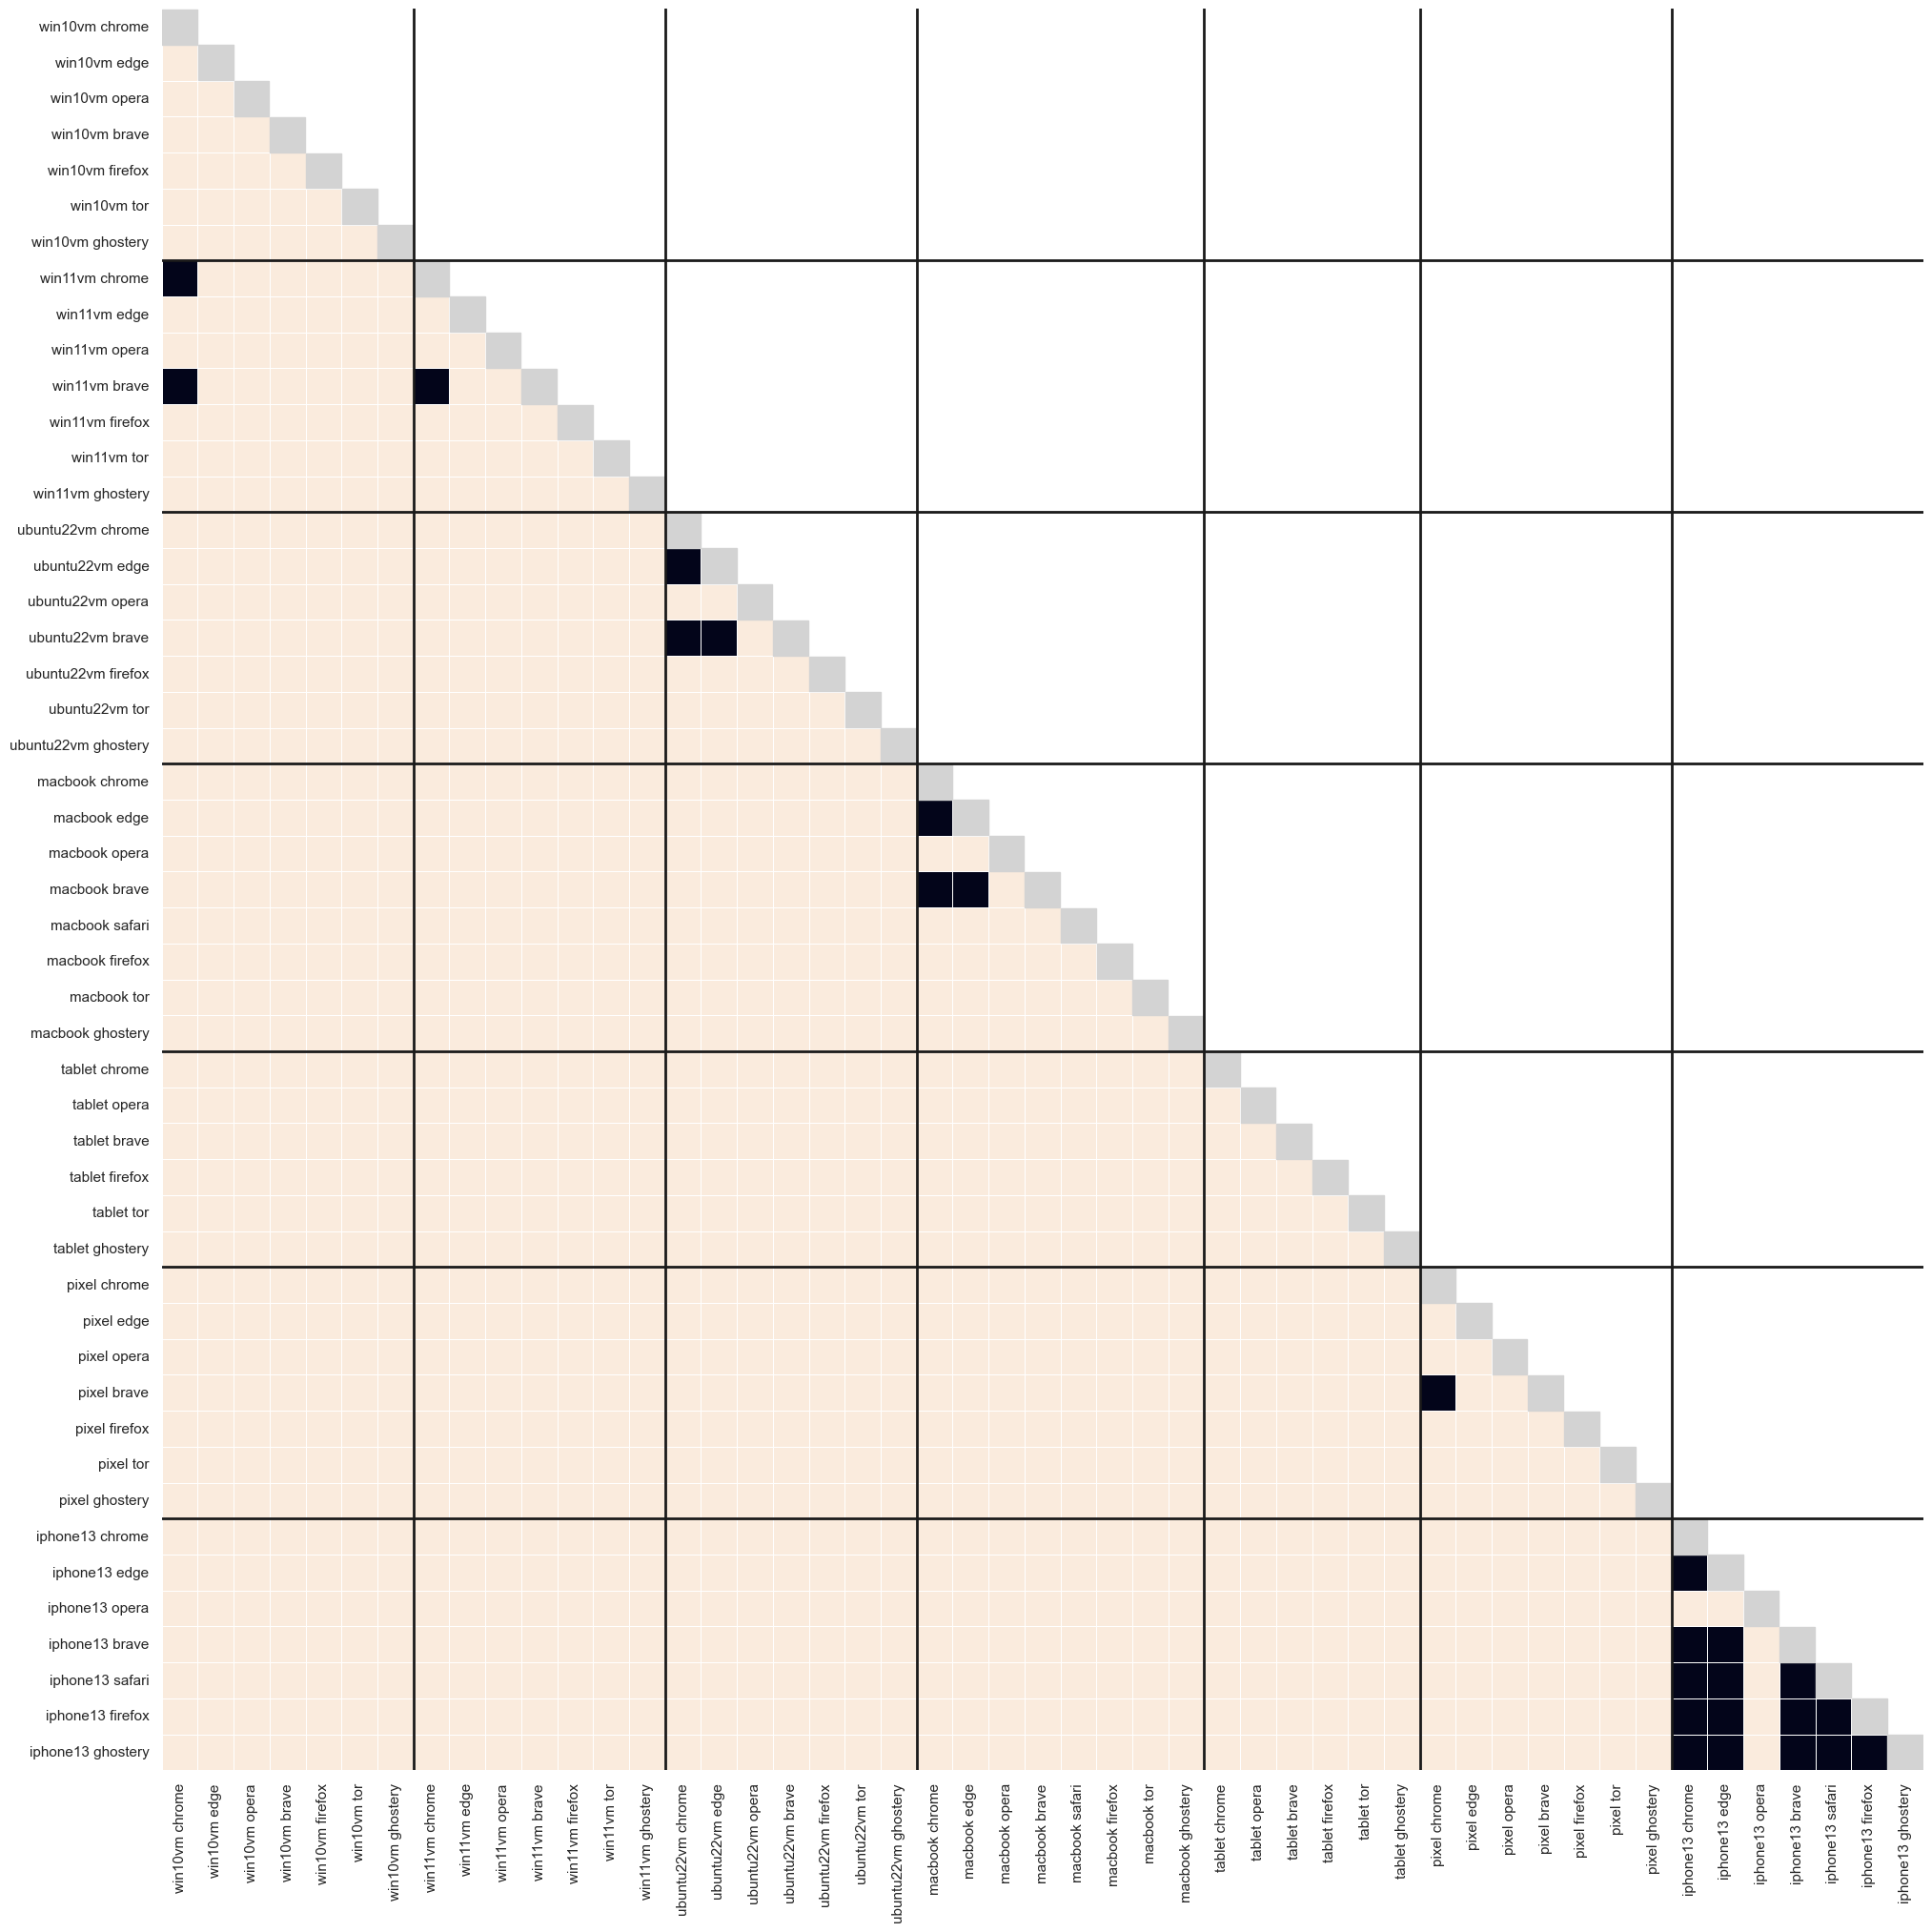

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
mask = np.triu(np.ones_like(df_cm, dtype=bool))

plt.figure(figsize=(30,24))
sn.set(font_scale=1.4)
sn.set_theme(style='white')

cmap = ListedColormap(['white'] + sn.color_palette("coolwarm").as_hex())

ax = sn.heatmap(df_cm, annot=False, annot_kws={"size": 16}, cbar=False, square=True, linewidths=0.5, mask=mask)
highlighted_ticks = [7, 14, 21, 29, 35, 42]

for tick in highlighted_ticks:
    ax.axhline(y=tick, color='k', linewidth=2)
    ax.axvline(x=tick, color='k', linewidth=2)

for i in range(len(df_cm)):
    rect = plt.Rectangle((i + 0.01, i + 0.01), 0.98, 0.98, fill=True, color='lightgrey', edgecolor='lightgrey')
    ax.add_patch(rect)

plt.show()

In [10]:
unique_combinations = set()
for a, b in combinations:
    if (a,b) not in unique_combinations and (b,a) not in unique_combinations:
        unique_combinations.add((a,b))
# (num_labels * num_labels - num_labels) / 2

In [11]:
browser_to_cluster = dict()
for cluster in clusters:
    for browser in clusters[cluster]:
        assert browser not in browser_to_cluster
        browser_to_cluster[browser] = cluster

num_distinct_combinations = sum([1 for a,b in unique_combinations if browser_to_cluster[a] != browser_to_cluster[b]])
print(f"Number of Combinations we can distinguish: {num_distinct_combinations}")
print(f"Number of Combinations: {len(unique_combinations)}")
print(f" = {(num_distinct_combinations / len(unique_combinations))*100:.2f}%")

Number of Combinations we can distinguish: 1151
Number of Combinations: 1176
 = 97.87%
